### Transformer 이해

챗봇을 만들기 위해 여러가지 방법론이 있는데 가장 대중적인 방법은 Seq2Seq Model, Transformer Model 등을 이용하는 방법

- 트랜스포머는 자연어 처리 분야에서 필수적으로 알아야 할 모델
- 언어 이해에 적합한 self-attention 메커니즘을 사용. 인코더-디코더 아키텍처로 구성
- BERT(트랜스포머 인코더 사용)나 GPT(트랜스포머 디코더 사용) 같은 최신 모델이 모두 트랜스포머에 기반
- 인코더 블록과 디코더 블록으로 구성된 인코더-디코더 신경망
- 꽤 복잡하지만 파이토치에 `nn.Transformer` 구현되어 있음

```python
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)
```

- 파이토치 한국어 공식사이트 참조
<!-- [이미지확인](https://tutorials.pytorch.kr/_images/transformer_architecture.jpg) -->
<img src="https://tutorials.pytorch.kr/_images/transformer_architecture.jpg" width="500">

- 필요라이브러리

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset


#### 기본 transformer 구조



In [2]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

    def forward(self):
        pass

#### Positional encoding

- 트랜스포머는 입력 시퀀스의 순서에 신경 쓰지 않음. 이를 해결하는 솔루션이 포지셔널 인코딩
- 위치에 따라 요소에 "중요도를 부여"하는 방식
- PositionalEncoding 모듈은 시퀀스 안에서 토큰의 상대적인 또는 절대적인 위치에 대한 어떤 정보를 주입
    - 다른 주파수의 Sine, cosine함수 사용

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 드롭 아웃
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


#### 모델 완성

- nn.Transformer는 전체 구조에서 가운데 부분 즉 멀티헤드 어텐션과 피드 포워드 등 을 처리

```pyhton
x = torch.rand(16, 32, 3)
y = x.tranpose(0, 2)  # [3, 32, 16]
z = x.permute(2, 1, 0)  # [3, 32, 16]
```

#### Target Masking

- 모델 구조의 오른쪽 아래, "Masked Multi-head Attention" 이라는 특수 블록이 존재

<img src="https://miro.medium.com/max/1050/1*UJlsQ-JvWhCd_2tqdhK2hw.png" width="600">

#### Padding Masking

- 텐서는 GPU에 저장할 수 있는 행렬이기 때문에 모든 차원이 같은 크기의 요소를 가져야


- 이야기한 두 개의 마스킹 행렬을 생성하려면 트랜스포머 모델을 확장해야 함
- 아래는 그 확장 모델

In [5]:
class Transformer(nn.Module):
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)


- 모델을 훈련하는 데 사용할 가짜 데이터 세트


In [6]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

#크기가 16인 배치 형태로 만들어 줍니다.
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size 크기가 아닌 경우 마지막 비트를 얻지 않도록 합니다.
        if idx + batch_size < len(data):
            # 여기서 배치의 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야 합니다.
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가합니다.
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length  - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


#### 훈련 및 검증

- 모델, 손실 함수 및 옵티마이저의 인스턴스를 생성



In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

d:\01_Programming\100_HugoBank\Mine\study-pytorch\torch-cpu-env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


- train_loop 구현
    - target tensor는 예측 중에 모델에 전달
    - 다음 단어를 숨기기 위해 target mask 가 생성
    - padding mask가 생성되어 모델에 전달

In [8]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # 이제 tgt를 1만큼 이동하여 <SOS>를 사용하여 pos 1에서 토큰을 예측합니다.
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input 및 tgt_mask를 전달하여 표준 training
        pred = model(X, y_input, tgt_mask)

        # Permute 를 수행하여 batch size 가 처음이 되도록
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)


#### Validation

- 유효성 검사 루프는 기울기를 업데이트하지 않는다는 점을 제외하고는 훈련 루프와 정확히 동일


In [9]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)


#### 훈련 및 검증 실행

에포크 10으로 모델을 훈련.

In [10]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):  
    # 나중에 plotting 하기위해
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)


Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5900
Validation loss: 0.3714

------------------------- Epoch 2 -------------------------
Training loss: 0.3790
Validation loss: 0.3087

------------------------- Epoch 3 -------------------------
Training loss: 0.3246
Validation loss: 0.2534

------------------------- Epoch 4 -------------------------
Training loss: 0.2918
Validation loss: 0.2186

------------------------- Epoch 5 -------------------------
Training loss: 0.2684
Validation loss: 0.2034

------------------------- Epoch 6 -------------------------
Training loss: 0.2517
Validation loss: 0.1771

------------------------- Epoch 7 -------------------------
Training loss: 0.2395
Validation loss: 0.1638

------------------------- Epoch 8 -------------------------
Training loss: 0.2299
Validation loss: 0.1520

------------------------- Epoch 9 -------------------------
Training loss: 0.2227
Validation loss: 0.1748

-------

- loss 가 감소하는것을 확인가능

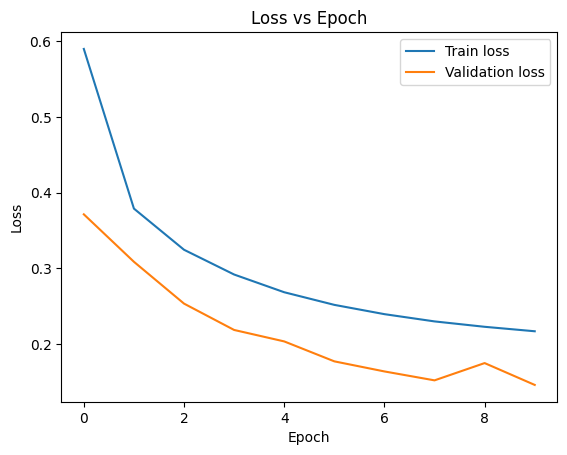

In [12]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

#### 추론

- 예측 함수를 만들어 테스트

In [13]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0]

